In [1]:
import pandas as pd
df = pd.read_csv("/home/marko/projects/tf216/br/br.csv")

In [2]:
print(list(df.columns))

['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'DEWP', 'DEWP_ATTRIBUTES', 'FRSHTT', 'FRSHTT_ATTRIBUTES', 'GUST', 'GUST_ATTRIBUTES', 'MAX', 'MAX_ATTRIBUTES', 'MIN', 'MIN_ATTRIBUTES', 'MXSPD', 'MXSPD_ATTRIBUTES', 'PRCP', 'PRCP_ATTRIBUTES', 'SLP', 'SLP_ATTRIBUTES', 'SNDP', 'SNDP_ATTRIBUTES', 'STP', 'STP_ATTRIBUTES', 'TEMP', 'TEMP_ATTRIBUTES', 'VISIB', 'VISIB_ATTRIBUTES', 'WDSP', 'WDSP_ATTRIBUTES']


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7969 entries, 0 to 7968
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   STATION            7969 non-null   int64  
 1   NAME               7969 non-null   object 
 2   LATITUDE           7969 non-null   float64
 3   LONGITUDE          7969 non-null   float64
 4   ELEVATION          7969 non-null   float64
 5   DATE               7969 non-null   object 
 6   DEWP               7969 non-null   float64
 7   DEWP_ATTRIBUTES    7969 non-null   int64  
 8   FRSHTT             7969 non-null   int64  
 9   FRSHTT_ATTRIBUTES  0 non-null      float64
 10  GUST               7969 non-null   float64
 11  GUST_ATTRIBUTES    0 non-null      float64
 12  MAX                7969 non-null   float64
 13  MAX_ATTRIBUTES     7969 non-null   object 
 14  MIN                7969 non-null   float64
 15  MIN_ATTRIBUTES     7969 non-null   object 
 16  MXSPD              7969 

In [4]:
df["DATE"] = pd.to_datetime(df["DATE"], format="%Y-%m-%d")

In [5]:
all_dates = pd.date_range(start=df["DATE"].min(), end=df["DATE"].max(), freq="D")
df = df.set_index("DATE")
df = df.reindex(all_dates)
df = df.reset_index()
df = df.rename(columns={"index": "DATE"})

In [6]:
df.drop(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'GUST', 'SNDP', 'FRSHTT', 'SLP', 'STP', 'PRCP', 'MXSPD', 'VISIB'], axis=1, inplace=True)
df.drop(['DEWP_ATTRIBUTES', 'FRSHTT_ATTRIBUTES', 'GUST_ATTRIBUTES', 'MAX_ATTRIBUTES', 'MIN_ATTRIBUTES', 'MXSPD_ATTRIBUTES', 'PRCP_ATTRIBUTES', 'SLP_ATTRIBUTES', 'SNDP_ATTRIBUTES', 'STP_ATTRIBUTES', 'TEMP_ATTRIBUTES', 'VISIB_ATTRIBUTES', 'WDSP_ATTRIBUTES'], axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8401 entries, 0 to 8400
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    8401 non-null   datetime64[ns]
 1   DEWP    7969 non-null   float64       
 2   MAX     7969 non-null   float64       
 3   MIN     7969 non-null   float64       
 4   TEMP    7969 non-null   float64       
 5   WDSP    7969 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 393.9 KB


In [8]:
import numpy as np
df['DEWP'] = df['DEWP'].replace(9999.9, np.nan)
df['WDSP'] = df['WDSP'].replace(999.9, np.nan)

In [9]:

print(df.isna().sum())

DATE      0
DEWP    435
MAX     432
MIN     432
TEMP    432
WDSP    677
dtype: int64


In [10]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df.loc[df.index.year == df.index.year.min()] = df.loc[df.index.year == df.index.year.min()].interpolate(method='linear')
for col in ['TEMP', 'MIN', 'MAX', 'DEWP', 'WDSP']:
   df[col] = df.apply(lambda row: 
                       df[(df.index.day == row.name.day) & (df.index.month == row.name.month) & 
                          (df.index.year < row.name.year)][col].mean() 
                       if pd.isna(row[col]) else row[col], axis=1)
df = df.reset_index().rename(columns={"index": "DATE"})

In [11]:
for col in ['TEMP', 'MIN', 'MAX', 'DEWP', 'WDSP']:
    df[col] = df[col].interpolate(method='linear', limit_direction='forward', axis=0)

In [12]:
nan_rows = df[df.isna().any(axis=1)]
print(nan_rows)


Empty DataFrame
Columns: [DATE, DEWP, MAX, MIN, TEMP, WDSP]
Index: []


In [13]:

for col in ['TEMP', 'MIN', 'MAX', 'DEWP', 'WDSP']:
    df[col] = df[col].round(1)
    
for col in ['TEMP', 'MIN', 'MAX', 'DEWP']:
    df[col] = (df[col] - 32) * 5/9
    df[col] = df[col].round(1)
    

df['WDSP'] = df['WDSP'] * 0.514444
df['WDSP'] = df['WDSP'].round(1)
    
def vapor_pressure(T):
    return 6.112 * np.exp((17.62 * T) / (243.12 + T))

df['DEWP'] = vapor_pressure(df['DEWP']) / vapor_pressure(df['TEMP'])
df = df.rename(columns={'DEWP': 'RHUM'})
df['RHUM'] = df['RHUM'].round(3)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8401 entries, 0 to 8400
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    8401 non-null   datetime64[ns]
 1   RHUM    8401 non-null   float64       
 2   MAX     8401 non-null   float64       
 3   MIN     8401 non-null   float64       
 4   TEMP    8401 non-null   float64       
 5   WDSP    8401 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 393.9 KB


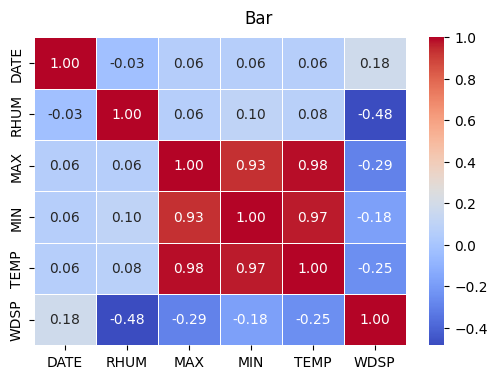

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.suptitle("Bar", fontsize=12, y=0.95)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, annot_kws={"size": 10}) 
plt.show()

In [16]:
for col in ['TEMP', 'MAX', 'MIN']:
    print(f"Correlations for {col}:")
    print(correlation_matrix[col].abs().sort_values(ascending=False), "\n")

Correlations for TEMP:
TEMP    1.000000
MAX     0.984143
MIN     0.966708
WDSP    0.252474
RHUM    0.077092
DATE    0.064973
Name: TEMP, dtype: float64 

Correlations for MAX:
MAX     1.000000
TEMP    0.984143
MIN     0.933811
WDSP    0.293537
RHUM    0.063567
DATE    0.058412
Name: MAX, dtype: float64 

Correlations for MIN:
MIN     1.000000
TEMP    0.966708
MAX     0.933811
WDSP    0.182934
RHUM    0.103772
DATE    0.061051
Name: MIN, dtype: float64 



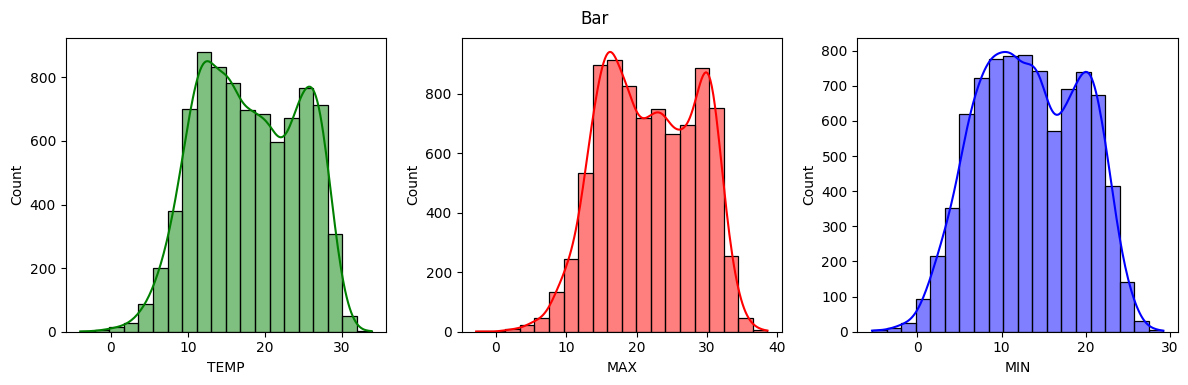

In [17]:
plt.figure(figsize=(12, 4))

plt.suptitle("Bar", fontsize=12, y=0.95)

plt.subplot(1, 3, 1)
sns.histplot(df['TEMP'], bins=20, kde=True, color='green')

plt.subplot(1, 3, 2)
sns.histplot(df['MAX'], bins=20, kde=True, color='red')

plt.subplot(1, 3, 3)
sns.histplot(df['MIN'], bins=20, kde=True, color='blue')

plt.subplots_adjust(top=0.85)

plt.tight_layout()
plt.show()

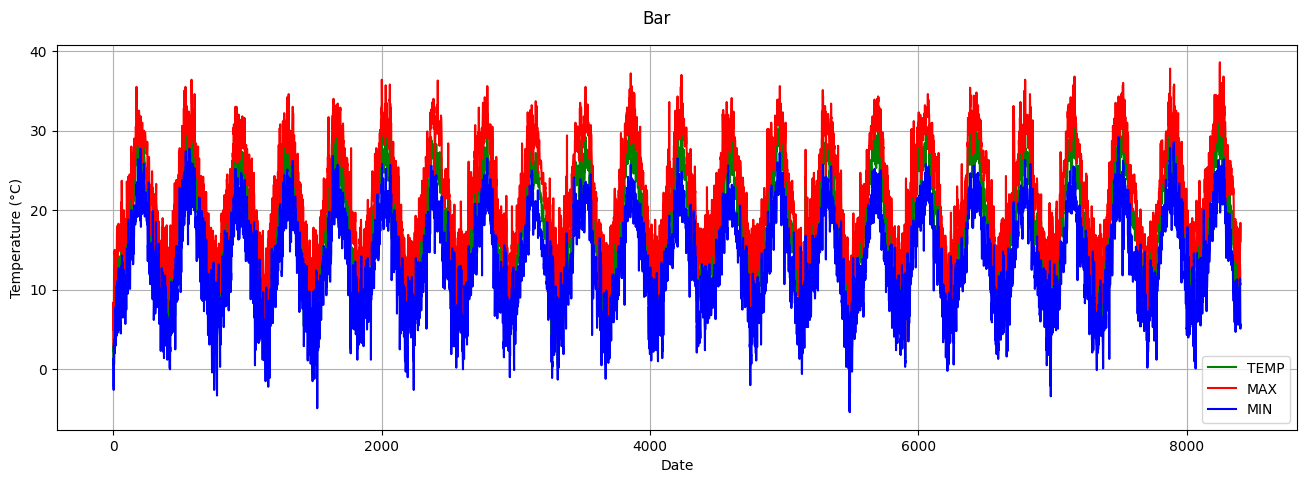

In [18]:
plt.figure(figsize=(16, 5))
plt.suptitle("Bar", fontsize=12, y=0.95)
plt.plot(df.index, df['TEMP'], label='TEMP', color='green')
plt.plot(df.index, df['MAX'], label='MAX', color='red')
plt.plot(df.index, df['MIN'], label='MIN', color='blue')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid()
plt.show()

In [19]:
df.to_csv("brfinal.csv", index=False)